# Cats vs Dogs vs Pandas
Here I have implemented a model that finds out whether a given image is of a Car or a Dog. 
There are 25,000 labelled cat and dog photos available for training and 12,500 in the test set.

In [1]:
# for automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torchvision import datasets, transforms, models
import torch
from torch import optim, nn
# from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# PATH_OF_DATASET = '/content/gdrive/"My Drive"/Cats-Dogs-Pandas/animals'

In [5]:
# !ls {PATH_OF_DATASET}

test  train


Now we have the path to the dataset in the variable `PATH_TO_DATASET`. To see the content of the folder we can run the bash` command:<br />     
``!ls PATH_OF_DATASET``<br />   
#### Loading Image Data
As we have the path, the easiest way to load image data is ``datasets.ImageFolder`` (when using Pytorch) from the ``torchvision``. Below code shows how to use that function:<br />     
```python
datasets.ImageFolder('path/to/data', transform = transforms)
```
where ``'path/to/data'`` is the file path to the data directory and ``transform`` is a sequence of processing steps which is built using the ``transforms`` module available in ``torchvision``. ``datasets.ImageFolder`` expects the files and directories to be constructed in a specific way as below: <br />     
``root/category_name/image_name``<br />    
``PATH_OF_DATASET/train/cats/cat_01000.jpg``<br />    
``PATH_OF_DATASET/train/dogs/dog_00140.jpg``<br />        
``PATH_OF_DATASET/test/pandas/panda_00998.jpg``
#### Transforms
Also we need to define some transforms. the images are different sizes but we'll need them to all be the same size for training. You can either resize them with ``transforms.Resize()`` or crop with ``transforms.CenterCrop()``, ``transforms.RandomResizedCrop()``, etc. We'll also need to convert the images to PyTorch tensors with ``transforms.ToTensor()``. Typically you'll combine these transforms into a pipeline with ``transforms.Compose()``, which accepts a list of transforms and runs them in sequence. It would look like: <br />      
```python
transforms.Compose([transforms.Resize(255),
                    transforms.CenterCrop(224),
                    transforms.ToTensor()])
```
#### Data Loaders
With the ``ImageFolder`` loaded, we will have to pass it to the ``DataLoader``. The ``DataLoader`` takes a dataset and returns batches of images and the corresponding labels. We can set various parameters like the batch size and if the data is shuffled after each epoch. <br />     
```python
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)
```
Here ``data_loader`` is a generator. To get data out of it, we will need to either loop through it or convert it to an **iterator** and call ``next()``.
```python
# looping through it, get a batch on each loop
for images, labels in dataloader:
    pass
  
# Get one batch
images, labels = next(iter(dataloader))
```
#### Data Augmentation
A common strategy for training neural network is to introduce randomness in the input data itself. We can randomly rotate, mirror, scale and crop our images during training. This will help the network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc. To randomly rotate, scale and crop, then flip the images, we need to define transforms like this:
```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])
```
We used ``transforms.Normalize`` to normalize the images, by passing a list of means and a list of standard deviations, then the color channels are normalizes like so <br />    
``input[channel] = (input[channel] - mean[channel]) / std[channel]``<br />    
Subtracting ``mean`` centers the data around zero and dividing by ``std`` squishes the value to be between ``-1`` and ``1``. Normalizing helps keep the network weights near zero which in turn makes the backpropagation more stable. Without normalization the network will tend to fail to learn.

In [3]:
PATH_OF_DATASET = 'animals'
# transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(PATH_OF_DATASET + "/train/", transform = train_transforms)
test_data  = datasets.ImageFolder(PATH_OF_DATASET + "/test",  transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size = 64, shuffle = True)

In [4]:
# a small function to plot the image
def plot_image(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

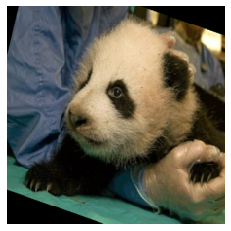

In [5]:
# getting a batch and plotting it
images, labels = next(iter(train_loader))
plot_image(images[4])

In [6]:
torch.cuda.is_available()

True

In [7]:
model = models.densenet161(pretrained = True)
# model

In [8]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = models.densenet201(pretrained = True)

# freeze parameters so that we dont backprop through them
for param in model.parameters():
  param.requires_grad = False


model.classifier = nn.Sequential(nn.Linear(1920, 512),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(512, 256),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(256, 3),
                                nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr = 0.005)

model.to(device)

cuda


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
# number of epochs
epochs = 1
steps = 0
running_loss = 0
# to print info after each 5 batches
print_every = 5

for epoch in range(epochs):
  
  for images, labels in train_loader:
    steps += 1
    
    # move data to gpu
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    log_ps = model.forward(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    if steps % print_every == 0:
      test_loss = 0
      accuracy = 0
      model.eval()
      with torch.no_grad():
        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          log_ps = model.forward(images)
          batch_loss = criterion(log_ps, labels)
          
          test_loss += batch_loss.item()
          
          # calculate accuracy
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
      print(f"Epoch {epoch+1}/{epochs}.. "
         f"Train loss: {running_loss / print_every:.3f}.. "
         f"Test loss: {test_loss / len(test_loader):.3f}.. "
         f"Test accuracy: {accuracy / len(test_loader):.3f}")
    
    
    running_loss = 0
    model.train()
    

Epoch 1/1.. Train loss: 0.285.. Test loss: 0.823.. Test accuracy: 0.497
Epoch 1/1.. Train loss: 0.167.. Test loss: 0.544.. Test accuracy: 0.664
Epoch 1/1.. Train loss: 0.071.. Test loss: 0.249.. Test accuracy: 0.958
Epoch 1/1.. Train loss: 0.052.. Test loss: 0.093.. Test accuracy: 0.978
Epoch 1/1.. Train loss: 0.037.. Test loss: 0.095.. Test accuracy: 0.970
Epoch 1/1.. Train loss: 0.045.. Test loss: 0.109.. Test accuracy: 0.964
Epoch 1/1.. Train loss: 0.039.. Test loss: 0.042.. Test accuracy: 0.992


In [10]:
# now lets get a batch of images and get the model make the predictions. 
# Then we will see if the prediction is correct or not on some images
# we will use the plot_image function to view the image
images_to_test, labels_to_test = next(iter(test_loader))
images_to_test = images_to_test.to("cuda")
the_predictions = model(images_to_test)
top_p, predicted_classes = the_predictions.topk(1, dim = 1)

Now ``predicted_classes`` contains the prediction for all ``64`` images that we sent in a batch. Lets randomly view a few and compare with the predicted output. The convention of the predition: <br />   
``0``: ``cat``<br />   
``1``: ``dog``<br />   
``2``: ``panda``

In [11]:
# move the images from cuda to cpu for plotting
images_to_test = images_to_test.to("cpu")
images_to_test.shape

torch.Size([64, 3, 224, 224])

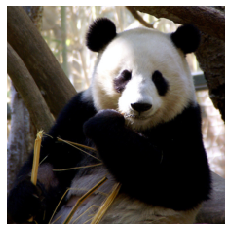

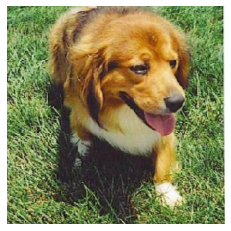

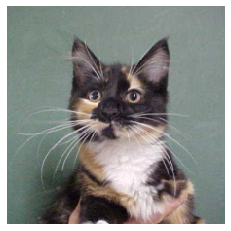

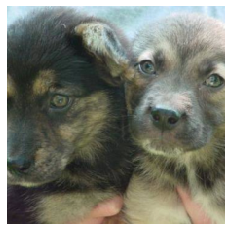

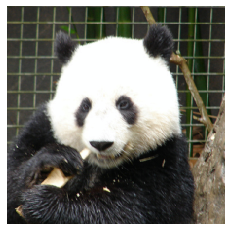

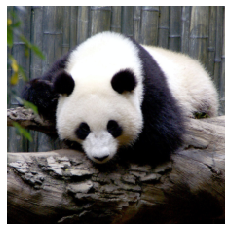

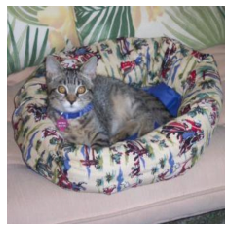

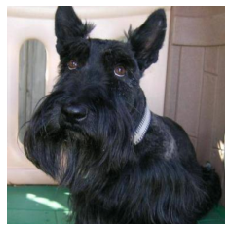

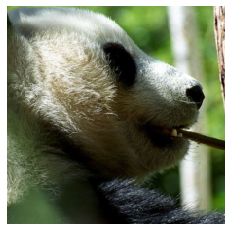

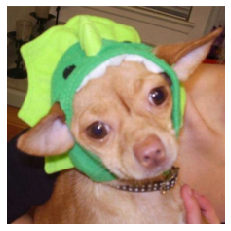

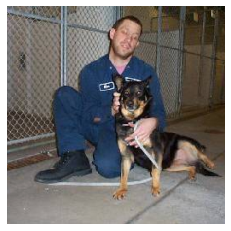

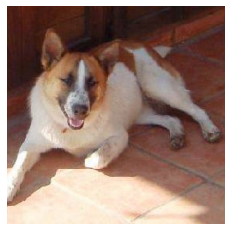

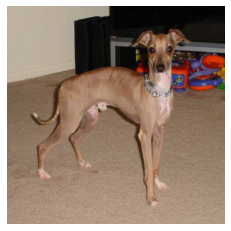

In [12]:
for i in range(len(images_to_test)):
  if i % 5 == 0:
    plot_image(images_to_test[i])

In [13]:
for i in range(len(images_to_test)):
  if i % 5 == 0:
    print(f"For image at position {i + 1}: {predicted_classes[i]}")

For image at position 1: tensor([2], device='cuda:0')
For image at position 6: tensor([1], device='cuda:0')
For image at position 11: tensor([0], device='cuda:0')
For image at position 16: tensor([1], device='cuda:0')
For image at position 21: tensor([2], device='cuda:0')
For image at position 26: tensor([2], device='cuda:0')
For image at position 31: tensor([0], device='cuda:0')
For image at position 36: tensor([1], device='cuda:0')
For image at position 41: tensor([2], device='cuda:0')
For image at position 46: tensor([1], device='cuda:0')
For image at position 51: tensor([1], device='cuda:0')
For image at position 56: tensor([1], device='cuda:0')
For image at position 61: tensor([1], device='cuda:0')


We can look at the images and match them ourselves for the received batch. All the predictions are **correct**.

# CHEERS!!